### Test Model

In [1]:
"""
Created on Tuesday 3 April 2022
Author: ZMW
"""
#import libraries

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.pipeline import make_pipeline
from numpy import mean
from numpy import std
from xgboost import plot_importance
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import shap
from sklearn.metrics import log_loss

In [2]:
# data path
path = os.getcwd()
dirname = os.path.dirname(path)
#for windown
#data_file = "data\\data.csv"
#for linux
data_file = 'data/data.csv'
data_path = os.path.join(dirname,data_file)

In [3]:
#Load the fitted dataset
data = pd.read_csv(data_path)

In [4]:
data.head()

,Label,Patient,A1_1Deg,A1_1Deg_err,B1_1Deg,B1_1Deg_err,C1_1Deg,C1_1Deg_err,1_Deg_ResSoS_1,1Deg_AdjR2_1,...,8_Deg_ResSoS_1,8Deg_AdjR2_1,A2_8Deg,A2_8Deg_err,B2_8Deg,B2_8Deg_err,C2_8Deg,C2_8Deg_err,8_Deg_ResSoS_2,8Deg_AdjR2_2
0,Not_Parkinson's,PD001,10.388190,0.006132,0.049329,0.000006,0.011989,0.000337,8928.709194,0.990598,...,6698.838281,0.951413,10.273124,0.044206,0.386347,0.000384,0.037356,0.002439,6809.455800,0.939095
1,Not_Parkinson's,PD002,10.429055,0.006929,0.049478,0.000007,0.002837,0.000379,11388.604704,0.988092,...,4769.901822,0.967360,11.482500,0.049154,0.395412,0.000380,-0.002486,0.002419,8383.481840,0.939586
2,Not_Parkinson's,PD003,10.097088,0.005091,0.049368,0.000006,0.005707,0.000287,6140.292312,0.993141,...,3488.747176,0.968709,10.084338,0.019838,0.394595,0.000174,-0.035466,0.001106,1349.962240,0.987259
3,Not_Parkinson's,PD004,10.482881,0.022179,0.049585,0.000023,0.016056,0.001212,117748.979710,0.879372,...,10972.045844,0.920137,11.493414,0.048867,0.401386,0.000377,-0.042463,0.002395,8242.136178,0.940370
4,Not_Parkinson's,PD005,10.181273,0.008833,0.049368,0.000010,0.001569,0.000494,18447.340517,0.979692,...,18268.960666,0.809586,10.370348,0.036121,0.395392,0.000308,-0.030769,0.001960,4485.300264,0.960035


In [5]:
# Features and labels
x = data.iloc[:,2:]
y = data.iloc[:,0]

In [6]:
## Convert the categorical variables to number
LabelEncoder_gender = LabelEncoder()
y = LabelEncoder_gender.fit_transform(y)

In [7]:
# spliting feature
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

### Hyperparameter tuning

In [8]:
# parameter list
n_estimators_list = [10, 50, 100, 200, 300, 400,500]
max_depth_list = range(3, 12)
min_samples_leaf_list = [1, 3, 5, 10, 20, 50]
max_features_list = ['sqrt', 'log2', 0.7, 0.8, 0.9]
min_samples_split_list = [2, 5, 10]

In [9]:
# parameters
params= {'n_estimators': hp.choice('n_estimators', [10,50,100,300,400,500]),
          'max_depth': hp.choice('max_depth', range(3, 12)),
          'min_samples_leaf': hp.choice('min_samples_leaf', [1, 3, 5, 10, 20, 50]),
          'min_samples_split':hp.choice('min_samples_split',[2,5,10]),
          'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 0.01),
          'max_features': hp.choice('max_features', ['sqrt', 'log2', 0.7, 0.8, 0.9])
          }

In [10]:
# Hyperparameter Tuning function
def hyperparameter_tuning(params):
    clf = RandomForestClassifier(**params)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
#   print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }


In [11]:
# Optimizing
trials = Trials()

best_hyperparams = fmin(fn = hyperparameter_tuning,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

100%|██████████| 50/50 [00:08<00:00,  5.92trial/s, best loss: -0.8888888888888888]


In [12]:
# Model with tuned parameters
best_model = RandomForestClassifier(n_estimators=n_estimators_list[best_hyperparams['n_estimators']],
                                    max_depth=max_depth_list[best_hyperparams['max_depth']],
                                    min_samples_leaf=min_samples_leaf_list[best_hyperparams['min_samples_leaf']],
                                    min_samples_split = min_samples_split_list[best_hyperparams['min_samples_split']],
                                    max_features=max_features_list[best_hyperparams['max_features']],
                                    min_impurity_decrease=best_hyperparams['min_impurity_decrease'],
                                    n_jobs=-1, random_state=1, verbose=0)

In [13]:
def run_best_model(arg):
    # data set preparation
    # data = pd.read_csv('data.csv')
    data = arg

    ## Convert the categorical variables to number
    LabelEncoder_gender = LabelEncoder()
    data['Label'] = LabelEncoder_gender.fit_transform(data['Label'])
    
    # run 30 repetitions
    splits = 30
    all_set = []
    for split in range(1,splits+1):
        
        seed = split

        # data set preparation
        train , test = train_test_split(data,train_size = 0.7,shuffle=True,random_state=seed)
        #validate , test = train_test_split(rest, train_size = 0.5, shuffle=True)

        # training set
        data_tra_x = train.iloc[:,2:].values
        data_tra_y = train.iloc[:,0].values


        # validation set
        # data_val_x = validate.iloc[:,2:].values
        # data_val_y = validate.iloc[:,0].values


        # test set
        data_tes_x = test.iloc[:,2:].values
        data_tes_y =  test.iloc[:,0].values

        best_model = RandomForestClassifier(n_estimators=n_estimators_list[best_hyperparams['n_estimators']],
                                    max_depth=max_depth_list[best_hyperparams['max_depth']],
                                    min_samples_leaf=min_samples_leaf_list[best_hyperparams['min_samples_leaf']],
                                    min_samples_split = min_samples_split_list[best_hyperparams['min_samples_split']],
                                    max_features=max_features_list[best_hyperparams['max_features']],
                                    min_impurity_decrease=best_hyperparams['min_impurity_decrease'],
                                    n_jobs=-1, random_state=1, verbose=0)
    
        best_model.fit(data_tra_x,data_tra_y)

        # training error
        tra_pred = best_model.predict_proba(data_tra_x)
        tra_results = [split,'tra',roc_auc_score(data_tra_y,tra_pred[:,1])]
      

        # validation error
        # val_pred = best_model.predict_proba(data_val_x)
        # val_results = [split,'val',roc_auc_score(data_val_y,val_pred[:,1])]
        

        # testing error
        tes_pred = best_model.predict_proba(data_tes_x)
        tes_results = [' ','tes',roc_auc_score(data_tes_y,tes_pred[:,1])]
    

        all_set += tra_results,tes_results

    all_set_df = pd.DataFrame(all_set,columns=['split','set','acc'])

    print('train accuracy',all_set_df[all_set_df['set'] == 'tra']['acc'].mean()),#'std',all_set_df[all_set_df['set'] == 'tra']['acc'].std())
    #print('validation accuracy',all_set_df[all_set_df['set'] == 'val']['acc'].mean(),'std',all_set_df[all_set_df['set'] == 'tra']['acc'].std())
    print('test accuracy',all_set_df[all_set_df['set'] == 'tes']['acc'].mean()),#'std',all_set_df[all_set_df['set'] == 'tes']['acc'].std())

#run_best_model(data)

In [14]:
run_best_model(data)

train accuracy 0.9996632996632997
test accuracy 0.6779629629629629


In [15]:
def run_best_model(arg):
    # data set preparation
    # data = pd.read_csv('data.csv')
    data = arg

    ## Convert the categorical variables to number
    LabelEncoder_gender = LabelEncoder()
    data['Label'] = LabelEncoder_gender.fit_transform(data['Label'])
    
    # run 30 repetitions
    splits = 30
    all_set = []
    for split in range(1,splits+1):
        
        seed = split

        # data set preparation
        train , test = train_test_split(data,train_size = 0.7,shuffle=True,random_state=seed)
        #validate , test = train_test_split(rest, train_size = 0.5, shuffle=True)

        # training set
        data_tra_x = train.iloc[:,2:].values
        data_tra_y = train.iloc[:,0].values


        # validation set
        # data_val_x = validate.iloc[:,2:].values
        # data_val_y = validate.iloc[:,0].values


        # test set
        data_tes_x = test.iloc[:,2:].values
        data_tes_y =  test.iloc[:,0].values

        best_model = RandomForestClassifier(n_estimators=n_estimators_list[best_hyperparams['n_estimators']],
                                    max_depth=max_depth_list[best_hyperparams['max_depth']],
                                    min_samples_leaf=min_samples_leaf_list[best_hyperparams['min_samples_leaf']],
                                    min_samples_split = min_samples_split_list[best_hyperparams['min_samples_split']],
                                    max_features=max_features_list[best_hyperparams['max_features']],
                                    min_impurity_decrease=best_hyperparams['min_impurity_decrease'],
                                    n_jobs=-1, random_state=1, verbose=0)
    
        best_model.fit(data_tra_x,data_tra_y)

        # training error
        tra_pred = best_model.predict_proba(data_tra_x)
        tra_results = [split,'tra',roc_auc_score(data_tra_y,tra_pred[:,1])]
      

        # validation error
        # val_pred = best_model.predict_proba(data_val_x)
        # val_results = [split,'val',roc_auc_score(data_val_y,val_pred[:,1])]
        

        # testing error
        tes_pred = best_model.predict_proba(data_tes_x)
        tes_results = [' ','tes',roc_auc_score(data_tes_y,tes_pred[:,1])]
    

        all_set += tra_results,tes_results

    all_set_df = pd.DataFrame(all_set,columns=['split','set','acc'])

    print('train accuracy',all_set_df[all_set_df['set'] == 'tra']['acc'].mean()),#'std',all_set_df[all_set_df['set'] == 'tra']['acc'].std())
    #print('validation accuracy',all_set_df[all_set_df['set'] == 'val']['acc'].mean(),'std',all_set_df[all_set_df['set'] == 'tra']['acc'].std())
    print('test accuracy',all_set_df[all_set_df['set'] == 'tes']['acc'].mean()),#'std',all_set_df[all_set_df['set'] == 'tes']['acc'].std())

#run_best_model(data)

In [16]:
run_best_model(data)

train accuracy 0.9996632996632997
test accuracy 0.6779629629629629


In [29]:
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
predictions = [round(value) for value in y_pred]

# Accuracy
accuracy = accuracy_score(y_test,predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.89%


In [124]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.60      1.00      0.75         3

    accuracy                           0.78         9
   macro avg       0.80      0.83      0.77         9
weighted avg       0.87      0.78      0.78         9



### Model with custom features

In [21]:
data = data[['Label','Patient','C2_6Deg','B2_4Deg','B2_6Deg','C2_4Deg',
            'C1_2Deg','C1_8Deg','A1_4Deg_err','C2_1Deg','B1_8Deg','B2_8Deg']]


def run_best_model(arg):
    # data set preparation
    # data = pd.read_csv('data.csv')
    data = arg

    ## Convert the categorical variables to number
    LabelEncoder_gender = LabelEncoder()
    data['Label'] = LabelEncoder_gender.fit_transform(data['Label'])
    
    # run 30 repetitions
    splits = 30
    all_set = []
    for split in range(1,splits+1):
        
        seed = split

        # data set preparation
        train , test = train_test_split(data,train_size = 0.7,shuffle=True,random_state=seed)
        #validate , test = train_test_split(rest, train_size = 0.5, shuffle=True)

        # training set
        data_tra_x = train.iloc[:,2:].values
        data_tra_y = train.iloc[:,0].values


        # validation set
        # data_val_x = validate.iloc[:,2:].values
        # data_val_y = validate.iloc[:,0].values


        # test set
        data_tes_x = test.iloc[:,2:].values
        data_tes_y =  test.iloc[:,0].values

        best_model = RandomForestClassifier(n_estimators=n_estimators_list[best_hyperparams['n_estimators']],
                                    max_depth=max_depth_list[best_hyperparams['max_depth']],
                                    min_samples_leaf=min_samples_leaf_list[best_hyperparams['min_samples_leaf']],
                                    min_samples_split = min_samples_split_list[best_hyperparams['min_samples_split']],
                                    max_features=max_features_list[best_hyperparams['max_features']],
                                    min_impurity_decrease=best_hyperparams['min_impurity_decrease'],
                                    n_jobs=-1, random_state=1, verbose=0)
    
        best_model.fit(data_tra_x,data_tra_y)

        # training error
        tra_pred = best_model.predict_proba(data_tra_x)
        tra_results = [split,'tra',roc_auc_score(data_tra_y,tra_pred[:,1])]
      

        # validation error
        # val_pred = best_model.predict_proba(data_val_x)
        # val_results = [split,'val',roc_auc_score(data_val_y,val_pred[:,1])]
        

        # testing error
        tes_pred = best_model.predict_proba(data_tes_x)
        tes_results = [' ','tes',roc_auc_score(data_tes_y,tes_pred[:,1])]
    

        all_set += tra_results,tes_results

    all_set_df = pd.DataFrame(all_set,columns=['split','set','acc'])

    print('train accuracy',all_set_df[all_set_df['set'] == 'tra']['acc'].mean()),#'std',all_set_df[all_set_df['set'] == 'tra']['acc'].std())
    #print('validation accuracy',all_set_df[all_set_df['set'] == 'val']['acc'].mean(),'std',all_set_df[all_set_df['set'] == 'tra']['acc'].std())
    print('test accuracy',all_set_df[all_set_df['set'] == 'tes']['acc'].mean()),#'std',all_set_df[all_set_df['set'] == 'tes']['acc'].std())

#run_best_model(data)

#run_best_model(data)

In [22]:
run_best_model(data)

train accuracy 0.9996632996632997
test accuracy 0.7905555555555556


In [13]:
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler

In [75]:
x = data.iloc[:,2:].values
sc_x = StandardScaler()
x = sc_x.fit_transform(x)
y = data.iloc[:,0]
LabelEncoder_gender = LabelEncoder()
y = LabelEncoder_gender.fit_transform(y)
model = RandomForestClassifier()
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, valid_scores = learning_curve(
    model, x, y, train_sizes=train_sizes, cv=10,scoring='roc_auc')
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(valid_scores, axis=1)
test_std = np.std(valid_scores, axis=1)

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zaw/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/Users/zaw/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zaw/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/zaw/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__


FixedFormatter should only be used together with FixedLocator


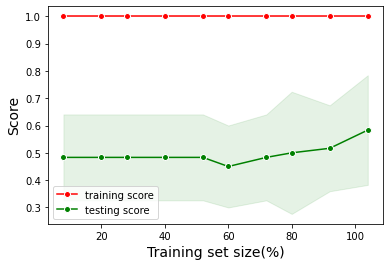

In [74]:
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)

valid_scores_mean = valid_scores.mean(axis = 1)
valid_scores_std = valid_scores.std(axis=1)
fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores_mean,"o-",markeredgecolor='white', label = 'training score',color='r')
ax.fill_between(train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
ax.plot(train_sizes, valid_scores_mean, "o-",markeredgecolor='w', label = 'testing score',color='g')
ax.fill_between(train_sizes,
        valid_scores_mean - valid_scores_std,
        valid_scores_mean + valid_scores_std,
        alpha=0.1,
        color="g",
    )
#ax.set_xticks([0,331,662,993,1324,1656])
ax.set_xticklabels([0,20,40,60,80,100,])
ax.set_ylabel('Score', fontsize = 14)
ax.set_xlabel('Training set size(%)', fontsize = 14)
#ax.set_title('Learning curve for a RF model', fontsize = 14, y = 1.03)
ax.legend()
#plt.savefig("rf_lc.png", format='png', dpi=600)
plt.show()

In [57]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=7)
# define the model
# model = xgb.XGBClassifier()
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
best_model.fit(X_train, y_train)
# evaluate performance
yhat = best_model.predict_proba(X_test)
score = log_loss(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
#results = best_model.evals_result()
# plot learning curves
# plt.plot(results['validation_0']['logloss'], label='train',ls='--')
# plt.plot(results['validation_1']['logloss'], label='test',ls='--')
# plt.xlabel('Training Set Size(%)')
# plt.ylabel('Loss')
# # show the legend
# plt.legend()
# # show the plot

# plt.savefig("loss.png", format='png', dpi=600)
# plt.show()

Accuracy: 0.701


NameError: name 'results' is not defined

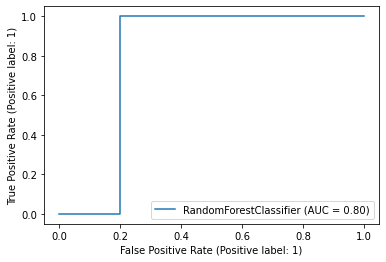

In [49]:
rf_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

[01:01:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


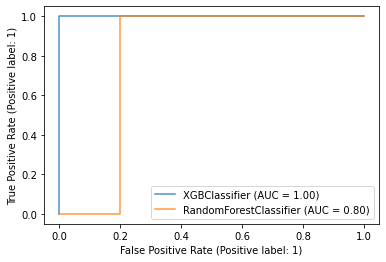

In [53]:
from sklearn.metrics import RocCurveDisplay
import xgboost as xgb
xgb_1 = xgb.XGBClassifier(n_estimators=10, random_state=42)
xgb_1.fit(X_train, y_train)
ax = plt.gca()
xgb_disp = RocCurveDisplay.from_estimator(xgb_1, X_test, y_test,ax=ax, alpha=0.8)
rf_disp.plot(ax=ax, alpha=0.8)
plt.show()